In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
import pickle

df = pd.read_csv("finalised_dataset.csv")
to_drop = ["Unnamed: 0", "state_names", "production", "area"]
df.drop(to_drop, axis="columns", inplace=True)
df.dropna(axis="rows", inplace=True)
print(df.shape)
df.head(3)

(12496, 13)


,district_names,crop_year,season_names,crop_names,temperature,wind_speed,pressure,humidity,soil_type,N,P,K,Yield
0,AHMEDNAGAR,1997,Autumn,Maize,20.770894,2.068260,1014.863796,21.947147,loamy,56.07,0.0,0.0,1113.000000
1,AHMEDNAGAR,1997,Kharif,Arhar/Tur,20.160426,1.976480,1015.193528,20.643237,sandy,9.00,9.0,0.0,0.357955
2,AHMEDNAGAR,1997,Kharif,Bajra,21.998299,2.000524,1014.184607,21.422312,clay,0.00,0.0,0.0,0.557461


-----------------------------------------

------------------------------------------------------------------

-----------------------------------

# Analysis of Dataset

### Analysis of average crop Yield Year-wise

In [ ]:
df.groupby(by='crop_year').mean()['Yield']

crop_year
1997    22.341557
1998     3.415268
1999     3.519748
2000     3.262697
2001     3.083085
2002     2.914333
2003     5.138871
2004     2.893499
2005     3.677714
2006     0.899084
2007     4.014252
2008     6.306082
2009     4.243727
2010     4.205582
2011     3.863737
2012     3.560567
2013     4.440736
2014     4.428971
Name: Yield, dtype: float64

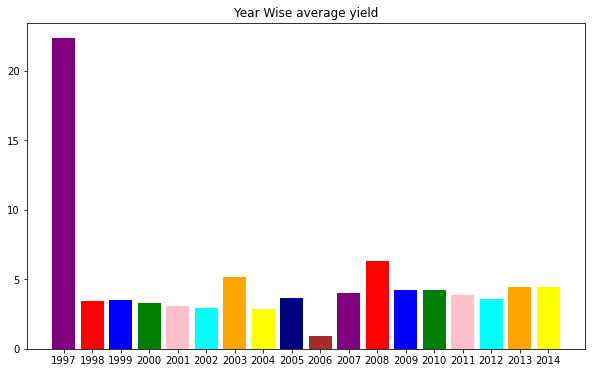

In [ ]:
x=df['crop_year'].unique().tolist()
y = pd.DataFrame(df.groupby(by='crop_year').mean())['Yield'].values.ravel()
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)
plt.bar(range(len(x)), y, tick_label=x, color=[
        'purple', 'red', 'blue', 'green', 'pink', 'cyan', 'orange', 'yellow', 'navy', 'brown'])
plt.title("Year Wise average yield")
plt.show()


1997 data is an outlier, hence dropping it

In [ ]:
df=df.query('crop_year>1997')

---------------------

--------------------

### Analysis of each categorical variable's average yield

#### District

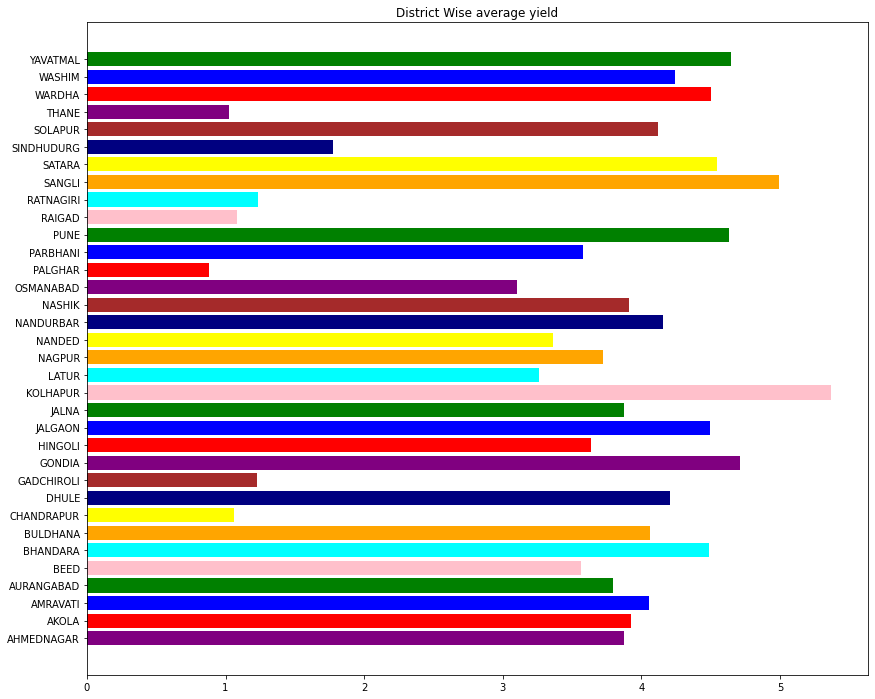

In [ ]:
x=df['district_names'].unique().tolist()
y = pd.DataFrame(df.groupby(by='district_names').mean())[
    'Yield'].values.ravel()
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(12)
plt.barh(range(len(x)), y, tick_label=x, color=[
        'purple', 'red', 'blue', 'green', 'pink', 'cyan', 'orange', 'yellow', 'navy', 'brown'])
plt.title("District Wise average yield")
plt.show()


#### Crop Name

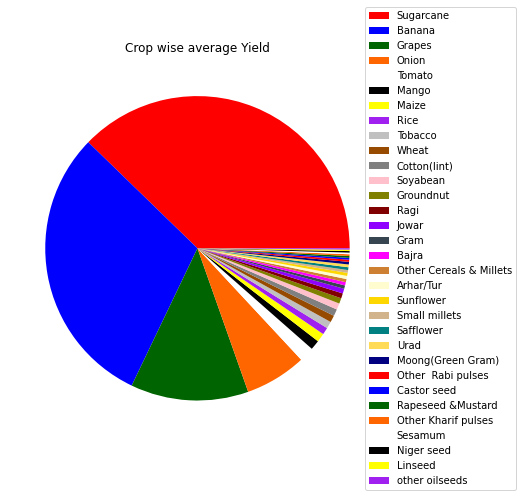

In [ ]:
colors=["#FF0000","#0000FF","#006400","#FF6600","#FFFFFF","#000000","#FFFF00","#A020F0",
        "#C0C0C0","#964B00","#808080","#FFC0CB","#808000","#800000","#8F00FF","#36454F",
        "#FF00FF","#CD7F32","#FFFDD0","#FFD700","#D2B48C","#008080","#FFDB58","#000080"]
x = pd.DataFrame(df.groupby(by='crop_names').mean()['Yield'].sort_values(ascending=False)).index.to_list()
y = pd.DataFrame(df.groupby(by='crop_names').mean())[
    'Yield'].sort_values(ascending=False).to_list()
fig, ax = plt.subplots(figsize=(10, 7))
patches, texts=ax.pie(y, colors=colors)
ax.legend(patches, x, loc="right", bbox_to_anchor=(1.35, 0.5))
plt.title("Crop wise average Yield")
plt.show()


#### Season

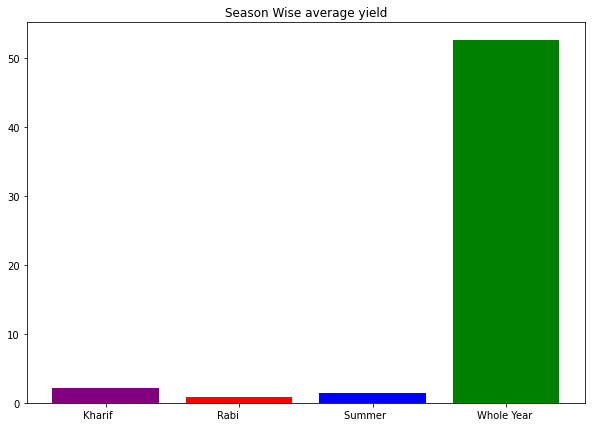

In [ ]:
x = df['season_names'].unique().tolist()
y = pd.DataFrame(df.groupby(by='season_names').mean())[
    'Yield'].values.ravel()
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.bar(range(len(x)), y, tick_label=x, color=[
        'purple', 'red', 'blue', 'green', 'pink', 'cyan', 'orange', 'yellow', 'navy', 'brown'])
plt.title("Season Wise average yield")
plt.show()


#### Soil type

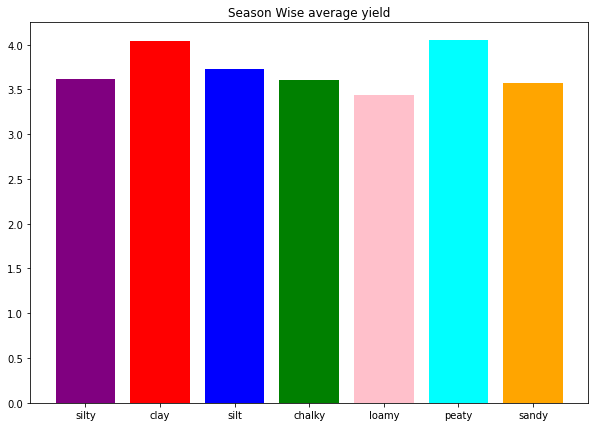

In [ ]:
x = df['soil_type'].unique().tolist()
y = pd.DataFrame(df.groupby(by='soil_type').mean())[
    'Yield'].values.ravel()
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.bar(range(len(x)), y, tick_label=x, color=[
        'purple', 'red', 'blue', 'green', 'pink', 'cyan', 'orange', 'yellow', 'navy', 'brown'])
plt.title("Season Wise average yield")
plt.show()


---------------------

-----------------------------------

### Correlation Analysis

In [ ]:
correlation = df.corr()
correlation['Yield'].sort_values(ascending=False)

Yield          1.000000
crop_year      0.023364
N              0.017335
humidity       0.011367
P              0.006495
pressure       0.003366
wind_speed    -0.001928
K             -0.003738
temperature   -0.004264
Name: Yield, dtype: float64

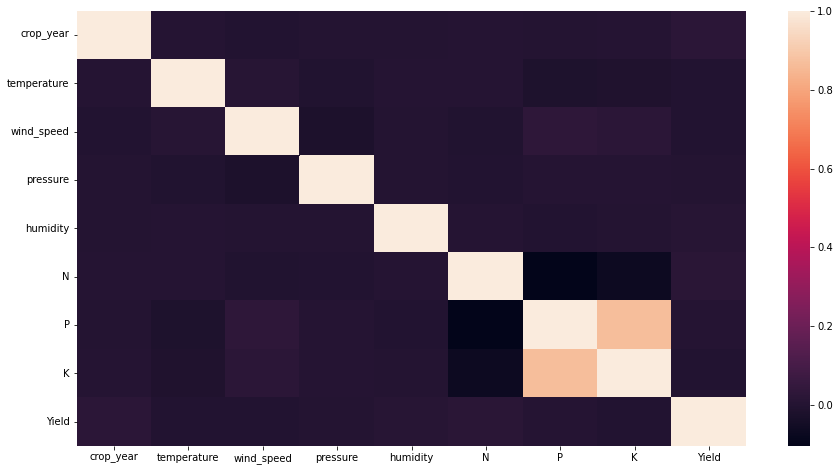

In [ ]:
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.heatmap(correlation)


-----------------------------

-------------------

----------------------

# Prediction Task

In [ ]:
df.head(2)

,district_names,crop_year,season_names,crop_names,temperature,wind_speed,pressure,humidity,soil_type,N,P,K,Yield
19,AHMEDNAGAR,1998,Kharif,Arhar/Tur,20.692897,2.087618,1014.739862,21.949998,silty,38.25,38.250,38.25,0.515957
20,AHMEDNAGAR,1998,Kharif,Bajra,20.988835,2.077557,1014.940241,20.615412,clay,0.00,26.832,0.00,0.806548


In [ ]:
features_4=df.columns.to_list()[0:4]          #primary features
features_8=df.columns.to_list()[0:8]          #primary features + weather features
features_12=df.columns.to_list()[0:12]        #primary features + weather features + soil features
features_to_train=[features_4, features_8, features_12]
features_to_train[2]

['district_names',
 'crop_year',
 'season_names',
 'crop_names',
 'temperature',
 'wind_speed',
 'pressure',
 'humidity',
 'soil_type',
 'N',
 'P',
 'K']

------------------------------

In [ ]:
X_train_list=[]
X_test_list=[]

y_train_list=[]
y_test_list=[]

for i in range(0,3):
    #defining independant and dependant variables
    X = df.loc[:, features_to_train[i]]
    y = df.loc[:, ['Yield']]

    #Categorical Variables treatment
    X = pd.get_dummies(X)

    #train_test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)



Trying 3 major

In [ ]:
resultdf1 = pd.DataFrame(index=["Features 4","Features 8","Features 12"], columns=[
    "RandomForestRegressor", "AdaBoostRegressor", "GradientBoostingRegressor"])
param = {'n_estimators': 1000}
    
for i in range(resultdf1.shape[0]):

    #RandomForest
    model1 = RandomForestRegressor(**param)
    model1.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model1.predict(X_test_list[i])
    resultdf1.iloc[i, 0] = r2_score(y_pred, y_test_list[i])

    #Adaboost
    model2 = AdaBoostRegressor(**param)
    model2.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model2.predict(X_test_list[i])
    resultdf1.iloc[i, 1] = r2_score(y_pred, y_test_list[i])

    #GradientBoosting
    model3 = GradientBoostingRegressor(**param)
    model3.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model3.predict(X_test_list[i])
    resultdf1.iloc[i, 2] = r2_score(y_pred, y_test_list[i])

resultdf1.to_excel("three-models.xlsx")

resultdf1


,RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
Features 4,0.970661,0.92026,0.966194
Features 8,0.958215,-3.000861,0.955383
Features 12,0.954324,0.529333,0.951459


----------------------------------------------------------------------

------------------------------------------------

Voting regressor

In [ ]:
resultdf2 = pd.DataFrame(index=["Features 4","Features 8","Features 12"], columns=[
    "Vote(RF+GB)", "Vote(AD+RF)", "Vote(GB+AD)", "Vote(RF+GB+AD)"])
resultdf2.head(4)

param = {'n_estimators': 1000}

for i in range(resultdf2.shape[0]):


#-----------------------------------------------------------------------------#
    #RandomForest + GradientBoosting
    estimators = [('rf', RandomForestRegressor(**param)),
                  ('gb', GradientBoostingRegressor(**param))]
    model1 = VotingRegressor(estimators=estimators)
    model1.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model1.predict(X_test_list[i])
    resultdf2.iloc[i, 0] = r2_score(y_pred, y_test_list[i])

#-----------------------------------------------------------------------------#
    #Adaboost + RandomForest
    estimators = [('ad', AdaBoostRegressor(**param)),
                  ('rf', RandomForestRegressor(**param))]
    model2 = VotingRegressor(estimators=estimators)
    model2.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model2.predict(X_test_list[i])
    resultdf2.iloc[i, 1] = r2_score(y_pred, y_test_list[i])

#-----------------------------------------------------------------------------#
    #GradientBoosting + Adaboost
    estimators = [('gb', GradientBoostingRegressor(**param)),
                  ('ad', AdaBoostRegressor(**param))]
    model3 = VotingRegressor(estimators=estimators)
    model3.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model3.predict(X_test_list[i])
    resultdf2.iloc[i, 2] = r2_score(y_pred, y_test_list[i])

#-----------------------------------------------------------------------------#
    #RandomForest + GradientBoosting + Adaboost
    estimators = [('rf', RandomForestRegressor(**param)),
                  ('gb', GradientBoostingRegressor(**param)),
                  ('ad', AdaBoostRegressor(**param))]

    model4 = VotingRegressor(estimators=estimators)
    model4.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model4.predict(X_test_list[i])
    resultdf2.iloc[i, 3] = r2_score(y_pred, y_test_list[i])

resultdf2.to_excel("Voting.xlsx")
resultdf2


,Vote(RF+GB),Vote(AD+RF),Vote(GB+AD),Vote(RF+GB+AD)
Features 4,0.970105,0.953286,0.952509,0.962881
Features 8,0.958397,-0.141171,0.307672,0.95433
Features 12,0.954647,0.942373,0.947047,0.748402


----------------------------------------------------------------------

----------------------------------------------------------------------

StackingRegressor

In [ ]:
resultdf3 = pd.DataFrame(index=["Features 4","Features 8","Features 12"], columns=[
    "Stack(RF+GB)", "Stack(AD+RF)", "Stack(GB+AD)", "Stack(RF+GB+AD)"])
resultdf3.head(4)

param = {'n_estimators': 1000}

for i in range(resultdf3.shape[0]):


#-----------------------------------------------------------------------------#
    #RandomForest + GradientBoosting
    estimators = [('rf', RandomForestRegressor(**param)),
                  ('gb', GradientBoostingRegressor(**param))]
    model1 = StackingRegressor(estimators=estimators)
    model1.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model1.predict(X_test_list[i])
    resultdf3.iloc[i, 0] = r2_score(y_pred, y_test_list[i])

#-----------------------------------------------------------------------------#
    #Adaboost + RandomForest
    estimators = [('ad', AdaBoostRegressor(**param)),
                  ('rf', RandomForestRegressor(**param))]
    model2 = StackingRegressor(estimators=estimators)
    model2.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model2.predict(X_test_list[i])
    resultdf3.iloc[i, 1] = r2_score(y_pred, y_test_list[i])

#-----------------------------------------------------------------------------#
    #GradientBoosting + Adaboost
    estimators = [('gb', GradientBoostingRegressor(**param)),
                  ('ad', AdaBoostRegressor(**param))]
    model3 = StackingRegressor(estimators=estimators)
    model3.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model3.predict(X_test_list[i])
    resultdf3.iloc[i, 2] = r2_score(y_pred, y_test_list[i])

#-----------------------------------------------------------------------------#
    #RandomForest + GradientBoosting + Adaboost
    estimators = [('rf', RandomForestRegressor(**param)),
                  ('gb', GradientBoostingRegressor(**param)),
                  ('ad', AdaBoostRegressor(**param))]

    model4 = StackingRegressor(estimators=estimators)
    model4.fit(X_train_list[i], y_train_list[i].values.ravel())
    y_pred = model4.predict(X_test_list[i])
    resultdf3.iloc[i, 3] = r2_score(y_pred, y_test_list[i])

resultdf3.to_excel("Stacking.xlsx")
resultdf3

,Stack(RF+GB),Stack(AD+RF),Stack(GB+AD),Stack(RF+GB+AD)
Features 4,0.970244,0.970049,0.966471,0.970024
Features 8,0.958609,0.959546,0.957037,0.959735
Features 12,0.955438,0.955198,0.945147,0.955307


-----------------------------------------

----------------------------